# Quality Prediction - Classification

In [1]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import xgboost as xgb
import numpy as np

In [2]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/204949


Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_reduced_new")
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_reduced_new",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

In [5]:
X = feature_view.get_batch_data()
X

Finished: Reading data from Hopsworks, using ArrowFlight (2.23s) from Hopsworks, using ArrowFlight.   


,type,volatile_acidity,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0,0.290,0.042,35.0,127.0,0.99370,3.45,0.50,10.2
1,1,0.640,0.075,14.0,31.0,0.99545,3.36,0.58,10.4
2,1,0.670,0.107,17.0,34.0,1.00040,3.28,0.98,9.9
3,0,0.260,0.052,54.0,160.0,0.99546,3.03,0.58,10.4
4,1,0.440,0.063,9.0,18.0,0.99444,3.04,0.69,11.3
...,...,...,...,...,...,...,...,...,...
5318,1,0.705,0.081,13.0,28.0,0.99631,3.23,0.66,10.2
5319,0,0.220,0.039,38.0,153.0,0.99940,3.34,0.42,9.0
5320,0,0.200,0.147,38.0,132.0,0.99300,3.06,0.38,9.1
5321,0,0.280,0.029,18.0,79.0,0.99230,3.35,0.52,11.8


Given that the relationships between features and the target variable are complex and nonlinear, we use Extreme Gradient Boosting as a model, in order to capture intricate patterns and interactions in the data.

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.57s) 


In [7]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [8]:
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
metrics

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 '4': {'precision': 0.1590909090909091,
  'recall': 0.14583333333333334,
  'f1-score': 0.15217391304347827,
  'support': 48},
 '5': {'precision': 0.45987654320987653,
  'recall': 0.40934065934065933,
  'f1-score': 0.4331395348837209,
  'support': 364},
 '6': {'precision': 0.42827868852459017,
  'recall': 0.4696629213483146,
  'f1-score': 0.4480171489817792,
  'support': 445},
 '7': {'precision': 0.3430232558139535,
  'recall': 0.33146067415730335,
  'f1-score': 0.33714285714285713,
  'support': 178},
 '8': {'precision': 0.034482758620689655,
  'recall': 0.041666666666666664,
  'f1-score': 0.03773584905660377,
  'support': 24},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 'accuracy': 0.39906103286384975,
 'macro avg': {'precision': 0.2035360221800027,
  'recall': 0.19970917926375392,
  'f1-score': 0.2011727575869199,
  'support': 1065},
 'weighted avg': {'precision': 0.4014095469483395,
 

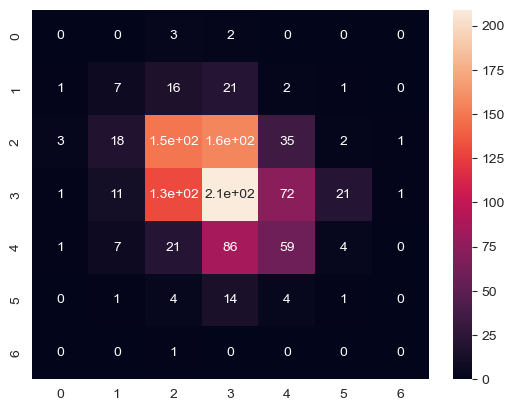

In [9]:
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

We can employ different classification approaches to highlight their differences and how fitting they are for the dataset. First, a logistic regression model can provide initial explorative analysis and see if the dataset presents notable linearity. More complex predictors can be leveraged to further extract information from the data.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

classifier = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_leaf=1, min_samples_split=2, random_state=50, class_weight = 'balanced')

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.50      0.08      0.14        48
           5       0.61      0.54      0.57       364
           6       0.50      0.71      0.59       445
           7       0.51      0.28      0.36       178
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1065
   macro avg       0.30      0.23      0.24      1065
weighted avg       0.52      0.53      0.51      1065



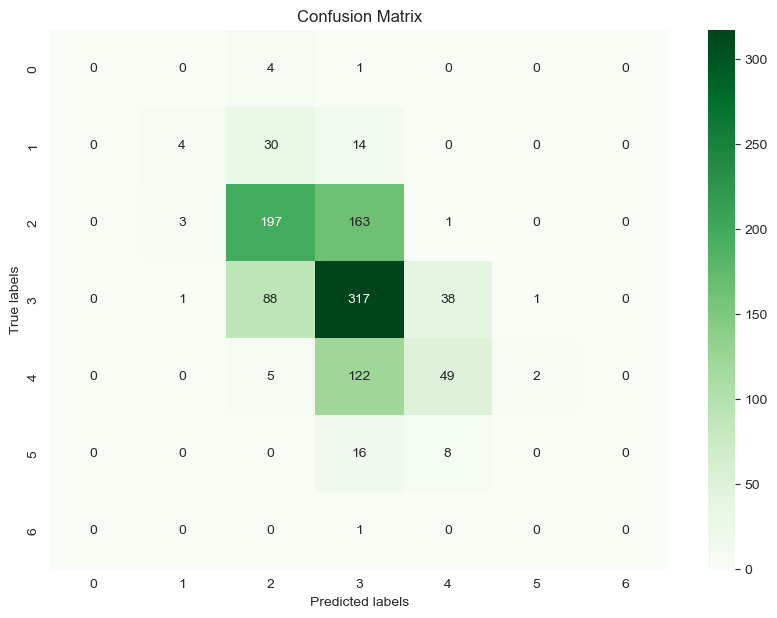

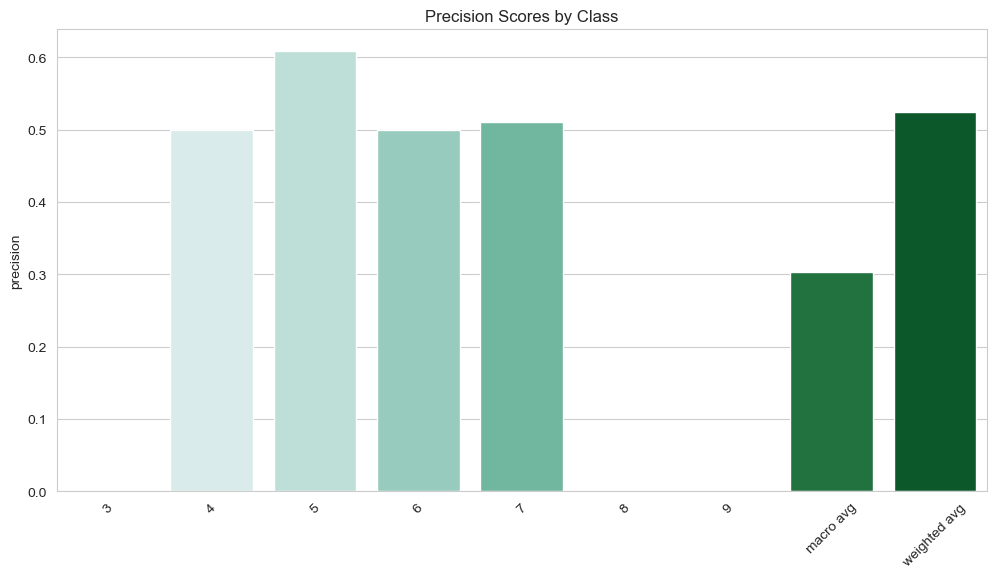

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report Visualization
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy'], inplace=True)  # Drop the total accuracy row
report_df['support'] = report_df['support'].apply(int)  # Convert support to int

# Plotting Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='precision', palette='BuGn')
plt.title('Precision Scores by Class')
plt.xticks(rotation=45)
plt.show()

In [22]:
! pip install imblearn

     -------------------------------------- 235.6/235.6 kB 7.0 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


We can train and visualize the outcomes of a logistic regression approach. As we can notice, the accuracy score is relatively low, only being slightly better than a random classifier. This is mostly due to the low support of classes 3,4,8,9, which the model is unable to predict efficiently.

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model_class"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(classifier, model_dir + "/wine_model_class.pkl")
fig.savefig(model_dir + "/confusion_matrix_class.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model_class",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/204949/models/wine_model_class/1


Model(name: 'wine_model_class', version: 1)